## 1. Sign Language (SL)
Ngôn ngữ ký hiệu là ngôn ngữ hình thể được sử dụng để giao tiếp với người điếc. Thông qua các thao tác, cử chỉ tay và biểu cảm gương mặt, những người điếc có thể dễ dàng truyền tải nội dung, ý muốn của mình tới người khác. 
Bài toán nhận diện ngôn ngữ ký hiệu ở đây áp dụng công nghệ Deep Learning giúp nhận diện những con số và chữ cái thông qua các hình ảnh cử chỉ bàn tay.
Chữ cái được đề cập ở đây gồm 26 chữ cái Latin gồm : a, b, c, d,..., x, y, z.

In [1]:
# Import packages and set numpy random seed
import os
import cv2
import pickle
import numpy as np
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, Flatten, Dense, AveragePooling2D


## 2. Prepare the dataset
Ta sẽ thực hiện tải dữ liệu, chia tập dữ liệu thành 3 phần: Test, Train, Validation và minh họa chúng.

In [2]:
path = './asl_dataset/'
data,label = [],[]
for root, dirs, files in os.walk(path):
    key = os.path.basename(root)
    for file in files:
        full_file_path = os.path.join(root,file)
        img = cv2.imread(full_file_path)
        img = cv2.resize(img,(128,128))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        data.append(img)
        label.append(key)

data = np.array(data)
label = np.array(label)


In [3]:
x_train, x_test0, y_train, y_test0 = train_test_split(data, label, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test0, y_test0, test_size=0.5)

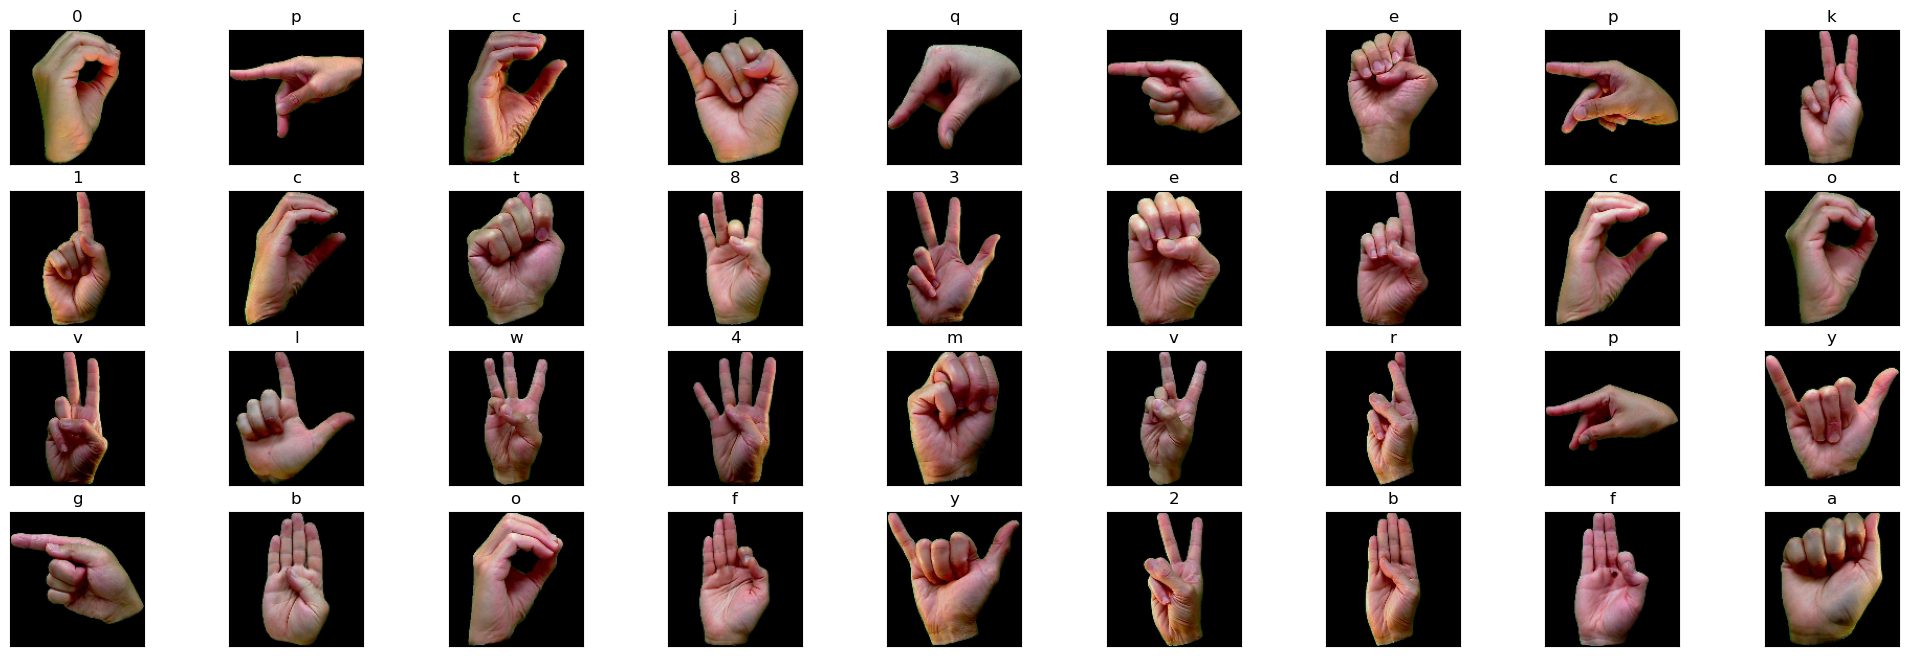

In [4]:

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(25,8))
for i in range(36):
    ax = fig.add_subplot(4, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(y_train[i]))
plt.show()

## 3. Examine the dataset


In [5]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(2012, 128, 128, 3)
(2012,)
(252, 128, 128, 3)
(252,)
(251, 128, 128, 3)
(251,)


## 4. Label encode the data
Thực hiện Label Encoder dữ liệu.
<p><img src="https://ekababisong.org/assets/seminar_IEEE/LabelEncoder.png" alt="one-hot encoding"></p>


In [6]:
le = preprocessing.LabelEncoder()
labelEnc_train = le.fit_transform(y_train)
labelEnc_test = le.fit_transform(y_test)
labelEnc_val = le.fit_transform(y_val)

In [7]:
labelEnc_train

array([ 0, 25, 12, ..., 29,  6, 20], dtype=int64)

In [8]:
print(x_train.shape)
print(labelEnc_train.shape)

(2012, 128, 128, 3)
(2012,)


## 5. Define the model
<p>Now it's time to define a convolutional neural network to classify the data.</p>
<p>This network accepts an image of an American Sign Language letter as input.  The output layer returns the network's predicted probabilities that the image belongs in each category.</p>
Xây dựng mạng neural tích chập để phân loại dữ liệu.
Đầu vào của mạng  là các ảnh của các số và chữ cái ký hiệu. Đầu ra của mạng trả về xác suất dự đoán của ảnh ở mỗi nhãn dán.

In [9]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

num_classes = 36

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(128,128,3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))
# Summarize the model
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 


 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 36)                4644      
                                                                 
Total params: 582756 (2.22 MB)
Trainable params: 582756 (2.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6. Compile the model


In [10]:
# Compile the model
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

## 7. Train the model

In [11]:
# Train the model
hist = model.fit(x_train, labelEnc_train, 
                    validation_data=(x_val,labelEnc_val), 
                    epochs=8, batch_size=32)

Epoch 1/8
63/63 [==============================] - 23s 347ms/step - loss: 8.9477 - accuracy: 0.5696 - val_loss: 0.8132 - val_accuracy: 0.7540
Epoch 2/8
63/63 [==============================] - 33s 522ms/step - loss: 0.4267 - accuracy: 0.8663 - val_loss: 0.3976 - val_accuracy: 0.8452
Epoch 3/8
63/63 [==============================] - 34s 539ms/step - loss: 0.2236 - accuracy: 0.9309 - val_loss: 0.5045 - val_accuracy: 0.8810
Epoch 4/8
63/63 [==============================] - 46s 727ms/step - loss: 0.1490 - accuracy: 0.9548 - val_loss: 0.3387 - val_accuracy: 0.9087
Epoch 5/8
63/63 [==============================] - 39s 628ms/step - loss: 0.0874 - accuracy: 0.9727 - val_loss: 0.6074 - val_accuracy: 0.8929
Epoch 6/8
63/63 [==============================] - 32s 501ms/step - loss: 0.1129 - accuracy: 0.9717 - val_loss: 0.1881 - val_accuracy: 0.9524
Epoch 7/8
63/63 [==============================] - 27s 427ms/step - loss: 0.0495 - accuracy: 0.9866 - val_loss: 0.2361 - val_accuracy: 0.9325
Epoch 

## 8. Test the model
Kiểm thử mô hình. Ở đây ta sử dụng độ chính xác để đo lường

In [12]:
# Obtain accuracy on test set
score = model.evaluate(x=x_test, 
                       y=labelEnc_test,
                       verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9442231059074402


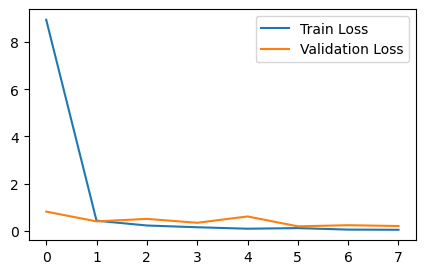

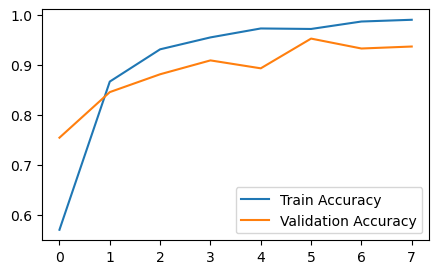

In [13]:
# Plot the loss value
plt.figure(figsize=(5,3))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot the accuracy value
plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

8/8 [==============================] - 1s 111ms/step


Text(0.5, 1.0, 'Confusion Matrix')

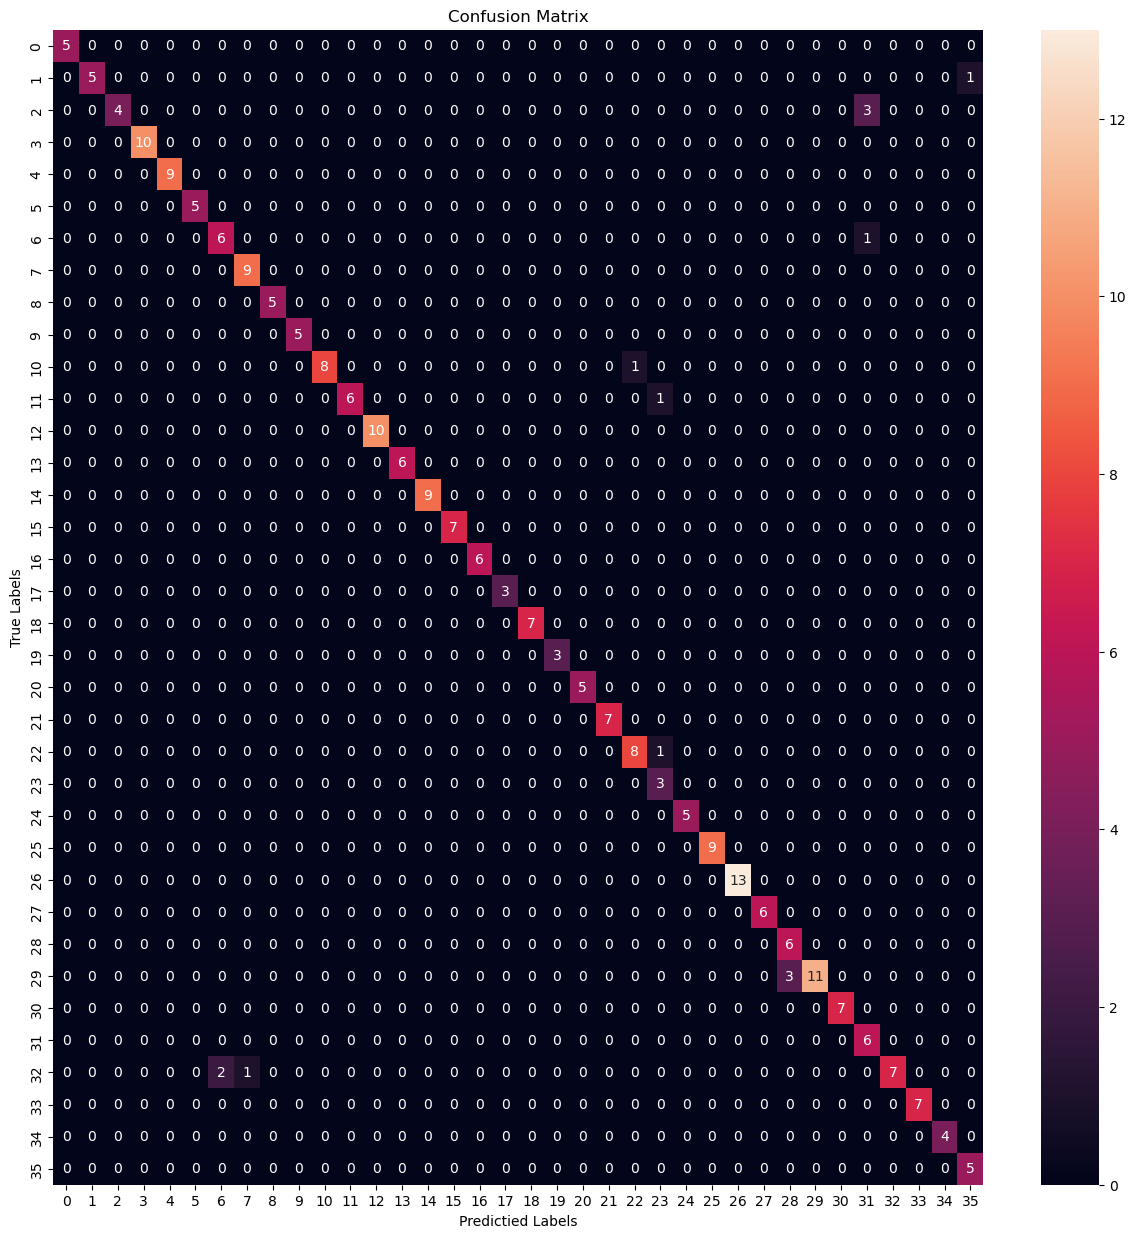

In [14]:
# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Confusion Matrix
cmatrix = confusion_matrix(y_preds, labelEnc_test)
fig, ax = plt.subplots(figsize=(15, 15))
sn.heatmap(cmatrix,annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predictied Labels');
ax.set_ylabel('True Labels');
ax.set_title('Confusion Matrix')

## 9. Visualize mistakes
Mô hình đạt độ chính xác khá cao nhưng cũng có những lỗi nhận diện sai do các ảnh có các chi tiết khá giống nhau. Sau đây là minh họa cho các lỗi nhận diện của mô hình.

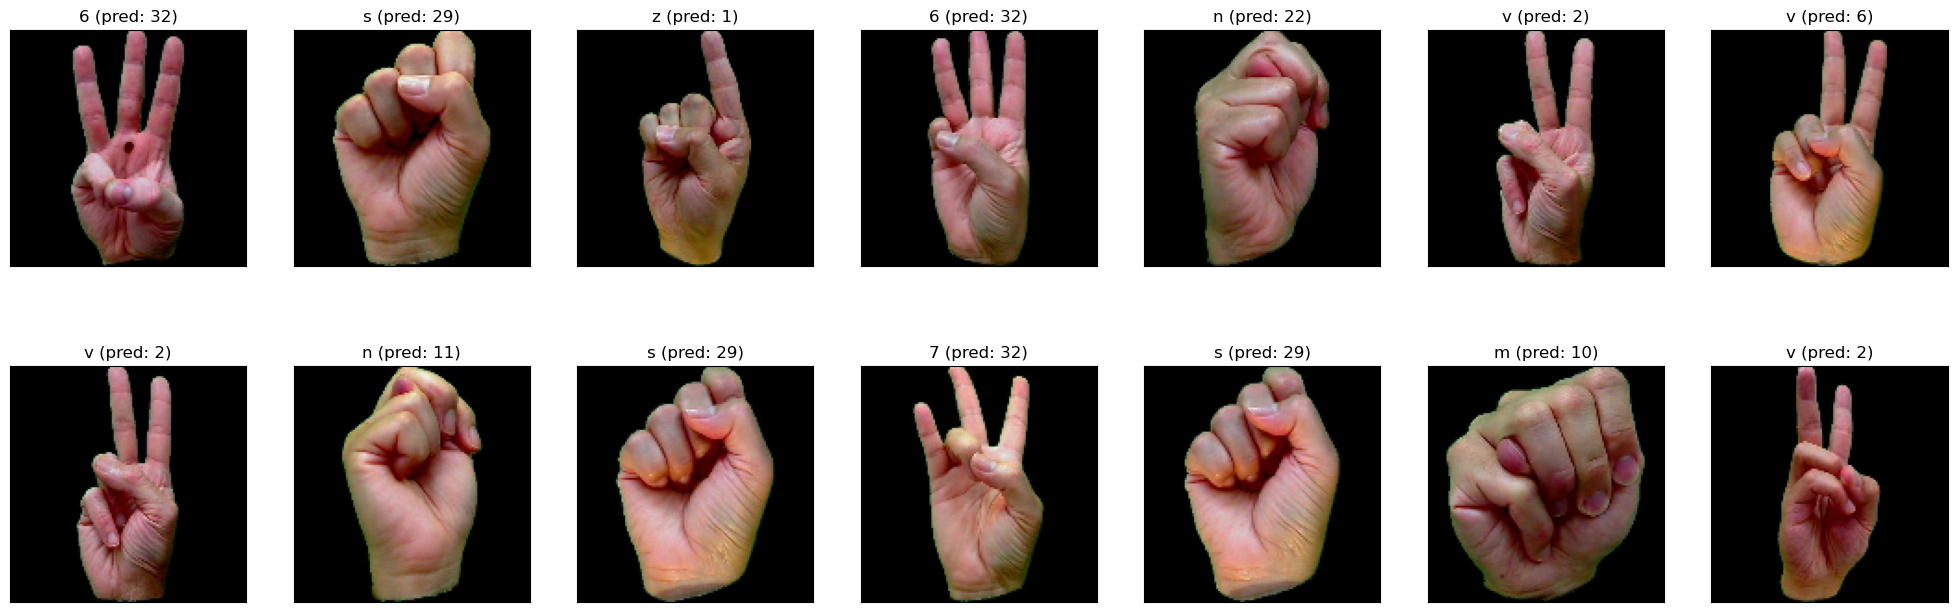

In [15]:


# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds != labelEnc_test)[0]


# Print mislabeled examples
fig = plt.figure(figsize=(25,8))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(2, int(np.ceil(len(bad_test_idxs)/2)), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{} (pred: {})".format(y_test[idx], y_preds[idx]))

In [ ]:
model.save("model.h5")


## 10. Interface Demo
Chạy thử Demo mô hình giao diện vừa tạo trên HuggingFace.

In [17]:
labels = np.unique(y_train)
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

In [18]:
mod = tf.keras.models.load_model('model.h5')

In [19]:

def predict_input_image(img):
    image = img.reshape(-1,128,128,3)
    prediction = mod.predict(image)[0]
    confidences = {labels[i]: float(prediction[i]) for i in range(36)}
    return confidences

In [ ]:
import gradio as gr
image = gr.inputs.Image(shape=(128,128))
label = gr.outputs.Label(num_top_classes=3)
gr.Interface(fn=predict_input_image, inputs=image, outputs=label,
             interpretation='default', title = "Sign Language Classification",
             examples=[
                "./asl_dataset/h/hand1_h_bot_seg_1_cropped.jpeg",
                "./asl_dataset/i/hand1_i_bot_seg_1_cropped.jpeg",
                "./asl_dataset/e/hand1_e_bot_seg_1_cropped.jpeg",
                "./asl_dataset/p/hand1_p_bot_seg_1_cropped.jpeg",
                "./asl_dataset/m/hand1_m_bot_seg_1_cropped.jpeg",
                "./asl_dataset/9/hand1_9_bot_seg_1_cropped.jpeg",
                "./asl_dataset/4/hand1_4_bot_seg_1_cropped.jpeg"
                       ]).launch(debug='True', share=True)

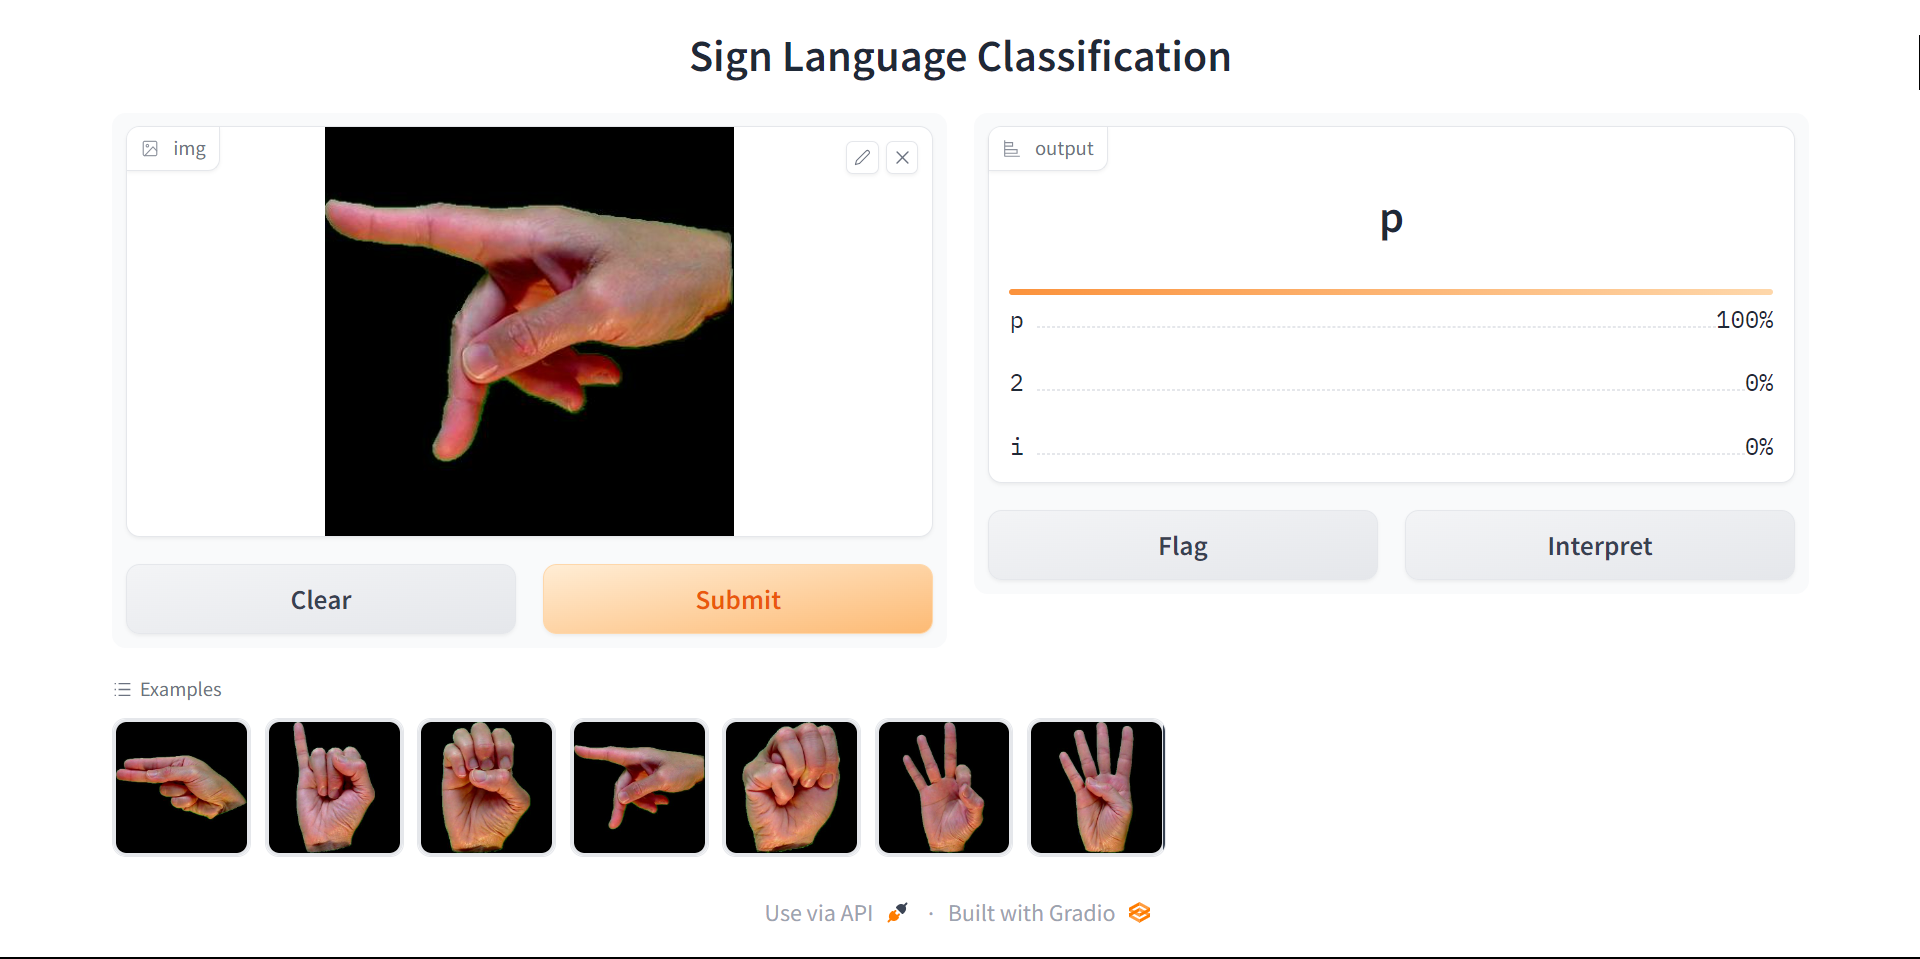